# IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
import math

## Helper Functions

## Loading Data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False) #dataframe referência
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False) #dataframe que será incorporado à referência

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, on = 'Store', how = 'left' )

# DESCRIÇÃO DOS DADOS

In [22]:
# Toda vez que mudar de seção é interessante fazer uma cópia do dataset para que, caso ocorra algum erro mais pra frente (tipo sobrescrever dados) não ser preciso rodar todo o notebook novamente.

df1 = df_raw.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Rename columns

- É importante renomear as colunas porque você ganha velocidade no desenvolvimento, colocando nomes mais curtos. Quando vc faz o SQL e traz o dataset para uma base única, os nomes das colunas foram escritos por programadores para facilitar com eles se lembrem deles na hora de trabalhar, mas isso não necessáriamente facilita para quem trabalha com dados. 

- df1.columns  (#está comentado porque poderia ter sido apagado)

- nesse caso, os nomes não estão ruins pq é uma base de dados do Kaggle (que já passou por uma organização. Mas os dados do mundo real não vem assim)

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename
df1.columns = cols_new


# verificando se deu certo a parte do rename

#### df1.columns (está comentado porque poderia ter sido apagado)

## Data Dimensions


In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 1017209
Number of cols: 18


## Data Types

In [7]:
# A coluna date vem como object. Importante transformá-la para o formato de data.

df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NAs

In [8]:
# Soma de todos os NAs

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

#### Existem 3 forma de lidar com os NAs

    - Não fazer nada, apenas excluí-los. Vantagem: é rápido e simples. Desvantagem: perde-se muita informação;
    - Usando algoritmos de ML que façam essa substituição baseados no comportamento da coluna; 
    - Pensando no negócio - Porque o negócio gerou esses NAs? Criar hipóteses (Meigaron recomenda)

#### competition_distance (distance in meters to the nearest competitor store)

    Assumption: Se a coluna está vazia pode ser porque não tem um competidor próximo ou porque eleestá tão longe que é como se não existisse competição. Vamos assumir que que quando está NA é pq o competidor está tão longe que é como se ele não existisse. Para isso, vamos preencher os NAs com uma distância maior que a distância máxima encontrada na coluna ('75860.0').

In [9]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

#### competition_open_since_month/year (gives the approximate year and month of the time the nearest competitor was opened)

    Assumption: Existem 2 razões para essa coluna estar vazia: 1- a loja não tem um competidor mais próximo 2 - a loja tem um competidor mais próximo mas a gente não sabe quando ele abriu. Se a competition_open_since_month for NA vamos copiar a data da venda pra essa coluna. Vamos manter essa coluna, pelo menos por enquanto, porque lá na frente ela pode ser necessária para explicar uma queda nas vendas (ocasionada pelo aparecimento de competidor)

In [10]:
# usa axis = 1 para falar que é pra fazer nas colunas

df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

#### promo2_since_week/year (describes the year and calendar week when the store started participating in Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating)

    Assumption: se os dados forem NAs quer dizer que a loja decidiu não participar dessa promoção. Substituir o NA pelo valor da data da venda naquela linha

In [11]:
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )

df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )

#### promo_interval (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)

    Assumption: Fazer um split dessa coluna e colocar os meses dentro de uma lista. Se a minha data estiver dentro dessa lista, criar uma coluna auxiliar falando que a promoção está ativa. 
                  

In [12]:
# criar coluna auxiliar
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

#### É importante checar novammente os tipos das colunas toda vez que a gente faz modificações. É importante também checar coluna por coluna para ver se estão nos tipos corretos.

#### Mudar as colunas 'competition_open_since_month' e 'competition_open_since_year' de float para int, porque tratam do numéro do mês e do ano.

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#### Mudar as colunas 'promo2_since_week ' e 'promo2_since_year' de float para int, porque tratam do numéro da semana e do ano.

In [15]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistical

#### Para que serve a descrição estatística dos dados?
    - Primeiro: pra gente ganhar conhecimento de negócio;
    - Segundo: pra gente conseguir detectar alguns erros;
    
    Dentro da estatística descritiva existem 2 grandes métricas (de primeira ordem):
    - métricas de tendência central: resumem os dados em um único número (Ex.: média e mediana);
    - métricas de dispersão: dizem se os resultados estão concentrados ou dispersos em relação a média (variância, std, range, min, max);
    
    Outras duas métricas estatísticas:
    - skewness: essencialmente mede a simetria da distribuição;
    - kutosis: determina o peso das caudas de distribuição;

#### Antes de calcular as métricas é preciso separar o conjunto de dados em variáveis numéricas e variáveis categóricas. A estatística descritiva funciona para os dois tipos de variáveis, mas a forma como eu construo a estatística é diferente. Para separar vamos criar dois datasets: um apenas com variáveis categóricas e outro apenas com variáveis numéricas;

In [16]:
num_attributes = df1.select_dtypes(include=[ 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=[ 'int64', 'float64', 'datetime64[ns]' ])

### Numerical Attributes

In [17]:
# Central tendency - mean, median

c1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, máx, range, skew, kurtosis 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [ d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


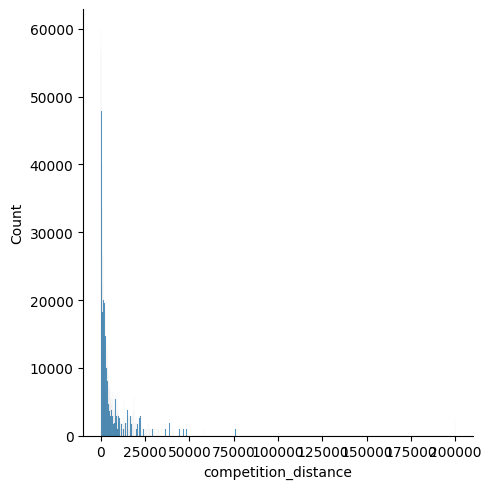

In [19]:
sns.displot( df1['competition_distance'])

### Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

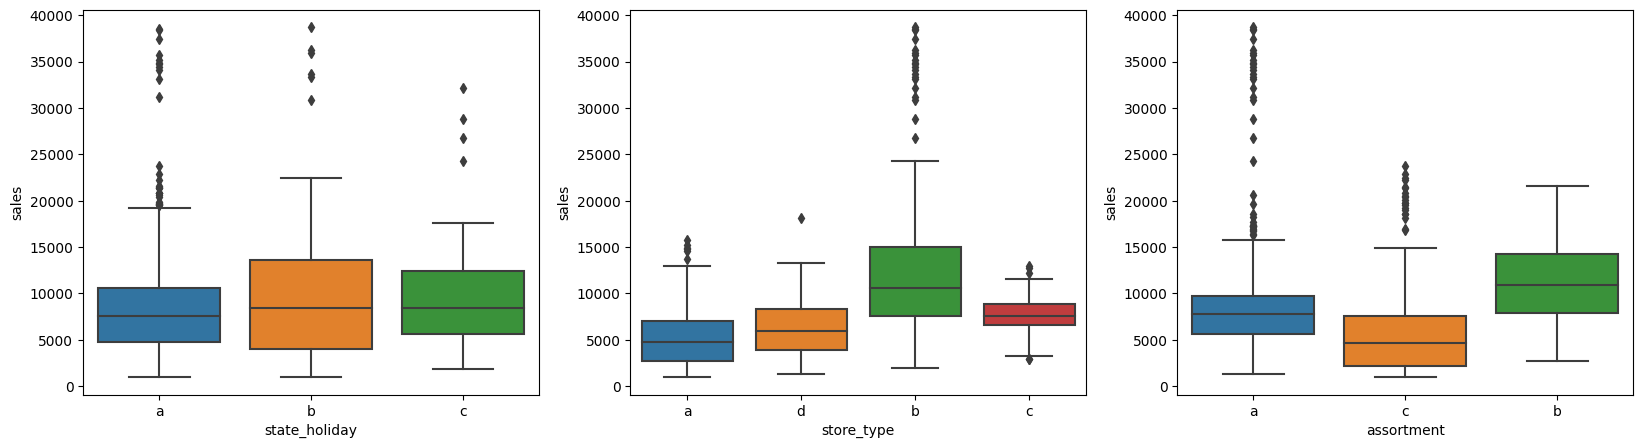

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0)]

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday' ,y = 'sales' ,data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type' ,y = 'sales' ,data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment' ,y = 'sales' ,data = aux1 )
